In [15]:
# All dependencies and functions are in _utils.py
# Make sure that _utils.py is in the same directory as this file
# Make sure that all dependencies are installed
from _utils import *

In [3]:
# Load observations 
# Load dataset from file
folder_path = './' # It is in current directory 

# There are 80 probes in this dataset 
num_monomers = 80

# There are two cell types:
# ESC (embryonic stem cells) and CNC (cranial neural crest cells)

# Load polys data and then perform linear interpolation
# List all .mat files in the folder and load them
cnc_polys = scipy.io.loadmat(folder_path + 'cncPols.mat')['cncPols'][:num_monomers, :, :]
esc_polys = scipy.io.loadmat(folder_path + 'escPols.mat')['escPols'][:num_monomers, :, :]

# Linear interpolation to fill in the missing values
# Better quality control in the future would be beneficial... 
esc_polys_interp = interpolate_polymers(esc_polys)
cnc_polys_interp = interpolate_polymers(cnc_polys)

# Convert 3D coordinates of polymers to distance maps
esc_maps_interp = calculate_distance_map(esc_polys_interp)
cnc_maps_interp = calculate_distance_map(cnc_polys_interp)

# Vectorize distance maps
esc_maps_interp_flat = np.array([x.flatten() for x in esc_maps_interp])
cnc_maps_interp_flat = np.array([x.flatten() for x in cnc_maps_interp])

In [7]:
# Plot the median maps of these distance maps 
# To check if the distance maps are reasonable
# axis=0 is the median of distances across all cells 
esc_maps_interp_median = np.median(esc_maps_interp, axis=0)  
cnc_maps_interp_median = np.median(cnc_maps_interp, axis=0)

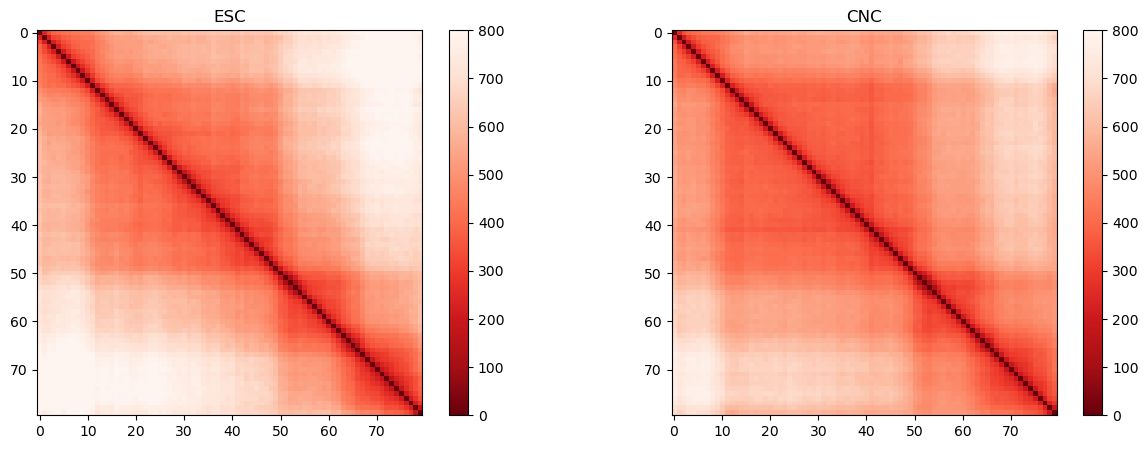

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].set_title('ESC')
axs[1].set_title('CNC')
# Add colorbars
fig.colorbar(axs[0].imshow(esc_maps_interp_median, cmap='Reds_r', vmax=800), ax=axs[0])
fig.colorbar(axs[1].imshow(cnc_maps_interp_median, cmap='Reds_r', vmax=800), ax=axs[1])

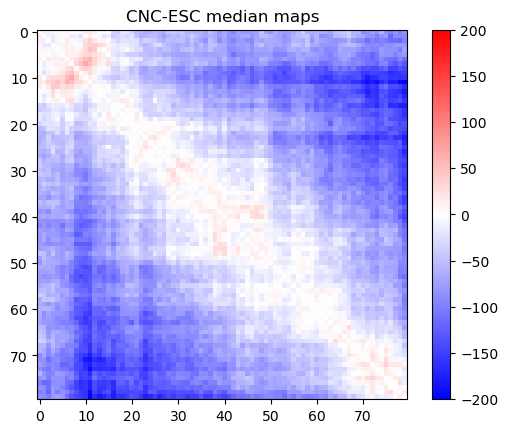

In [25]:
# Plot subtraction of ESC and CNC median maps
subtraction_maps = cnc_maps_interp_median - esc_maps_interp_median
plt.imshow(subtraction_maps, cmap='bwr', vmax=200, vmin=-200)
plt.title('CNC-ESC median maps')
plt.colorbar()
# The whole region is getting closer in CNC cells compared to ESC cells

In [26]:
# Concatenate all vectorized distance maps
# This is all the observations
# We are defining PC axis from this object 
all_maps_interp_flat = np.concatenate((esc_maps_interp_flat, cnc_maps_interp_flat), axis=0)

pca = PCA(n_components=2)
pca.fit(all_maps_interp_flat)
esc_maps_pca = pca.transform(esc_maps_interp_flat)
cnc_maps_pca = pca.transform(cnc_maps_interp_flat)

# Put it in a DataFrame for easy plotting
esc_df = pd.DataFrame(esc_maps_pca, columns=['PC1', 'PC2'])
esc_df['label'] = 'ESC'
cnc_df = pd.DataFrame(cnc_maps_pca, columns=['PC1', 'PC2'])
cnc_df['label'] = 'CNC'
all_df = pd.concat([esc_df, cnc_df], axis=0)

# Find the lower and upper bounds of the PC1 and PC2 axes
min_PC1 = min(all_df['PC1'])
max_PC1 = max(all_df['PC1'])
min_PC2 = min(all_df['PC2'])
max_PC2 = max(all_df['PC2'])

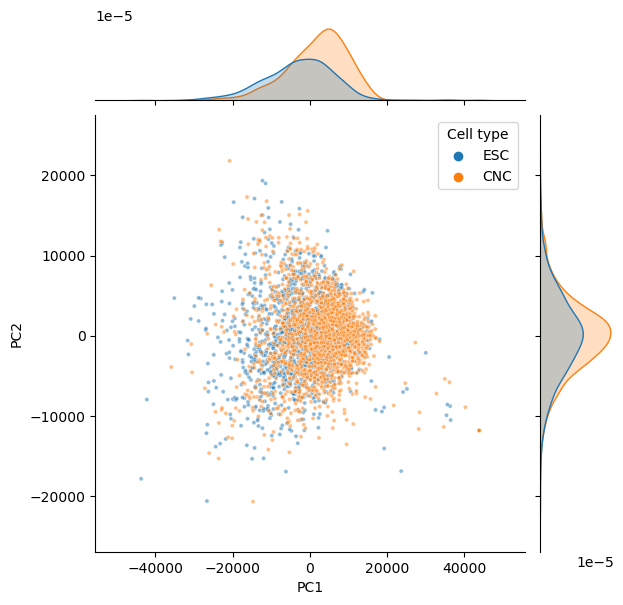

In [31]:
# Sanity check
# Plot PCA of ESC and CNC cells
sns.jointplot(data=all_df, x='PC1', y='PC2', hue='label', marker='.', alpha=0.5)
plt.legend(loc="best", title="Cell type")

In [33]:
# This function defines microstates based on PC1 and PC2 grid points
def generate_microstates(min_pc1, max_pc1, min_pc2, max_pc2, num_microstates, pca_model):
    """
    Generates a grid of points (microstates) based on provided PCA components ranges, 
    sorts them, and applies inverse transformation using the given PCA model.
    
    Parameters:
    ----------
    min_pc1 : float
        Minimum value for the first principal component (PC1).
    max_pc1 : float
        Maximum value for the first principal component (PC1).
    min_pc2 : float
        Minimum value for the second principal component (PC2).
    max_pc2 : float
        Maximum value for the second principal component (PC2).
    num_microstates : int
        Number of microstates (grid points) to generate for each component.
    pca_model : sklearn.decomposition.PCA
        Pre-trained PCA model that will be used to inverse transform the generated grid points.
    
    Returns:
    -------
    np.ndarray
        A NumPy array containing the inverse-transformed microstates.
    
    Example:
    -------
    microstates = generate_microstates(-5, 5, -5, 5, 75, pca_model)
    """
    
    # Create a grid of points
    pc1 = np.linspace(min_pc1, max_pc1, num_microstates)
    pc2 = np.linspace(min_pc2, max_pc2, num_microstates)
    pc1, pc2 = np.meshgrid(pc1, pc2)
    pc1 = pc1.flatten()
    pc2 = pc2.flatten()

    # Create a DataFrame from the grid points
    grid = pd.DataFrame({'PC1': pc1, 'PC2': pc2})

    # Sort PC2 in descending order while keeping PC1 in ascending order
    grid_sorted = grid.sort_values(by=['PC1', 'PC2'], ascending=[True, False], ignore_index=True)

    # Apply inverse transformation using the provided PCA model
    # README: This is where we get the microstates as a set of vectorized distance maps
    microstates = pca_model.inverse_transform(grid_sorted)

    return microstates

In [34]:
# Generate candidate microstates
num_microstates_per_axis = 75
microstates = generate_microstates(min_PC1, max_PC1, min_PC2, max_PC2, num_microstates_per_axis, pca)

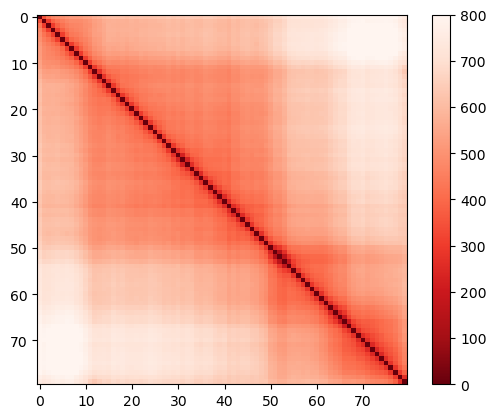

In [37]:
# Plot a microstates that are in the middle of the PC1 and PC2 axes
plt.imshow(microstates[len(microstates)//2].reshape(80, 80), cmap='Reds_r', vmax=800)
plt.colorbar()
# There are multiple structures that produce this microstate - can we do better? 